## What is Sentiment Analysis?
Sentiment Analysis, also known as Opinion Mining, is one of the common research areas which performs Natural Language Processing (NLP) tasks for the purpose to extract subjective information by analyzing text data written by users. In the case of sentiment analysis of review data, the main goal is to identify the user’s subjectivity and classify the statements into different groups of sentiments.

## Why Sentiment Analysis?
Sentiment analysis tools are essential to detect and understand customer feelings. Companies that use these tools to understand how customers feel can use it to improve CX. Sentiment analysis tools generate insights into how companies can enhance the customer experience and improve customer service.

## Content
- About the Dataset
- Text Preprocessing & Lemmatization
- Word Vectorization (BOW vs. TF-IDF)
- Implementing ML Classifiers & Evaluation Metrics
- Results
- Hyperparameter Tuning
- Discussion
- Future Work

## Required Python Libraries

In [1]:
import os, json, gzip 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from nltk.corpus import wordnet, stopwords

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Dataset

In [2]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz

--2022-10-06 09:12:37--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 495854086 (473M) [application/x-gzip]
Saving to: ‘reviews_Electronics_5.json.gz’

reviews_Electronics 100%[===================>] 472.88M  51.6MB/s    in 8.9s    

2022-10-06 09:12:46 (53.2 MB/s) - ‘reviews_Electronics_5.json.gz’ saved [495854086/495854086]



- `The raw data is compressed in gzip format, hence extra codes are needed to store the data into pandas DataFrame format.`

In [3]:
data = []
with gzip.open('reviews_Electronics_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
df = pd.DataFrame.from_dict(data)

In [4]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011"


### `Lets drop the unwanted Columns`

For training of model we will be only focusing on ‘reviewText’ and ‘overall’ columns, so let’s only keep these columns.

In [5]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [6]:
dfextracted = df[['reviewText', 'overall']]

In [7]:
dfextracted.head()

,reviewText,overall
0,We got this GPS for my husband who is an (OTR)...,5.0
1,"I'm a professional OTR truck driver, and I bou...",1.0
2,"Well, what can I say. I've had this unit in m...",3.0
3,"Not going to write a long review, even thought...",2.0
4,I've had mine for a year and here's what we go...,1.0


In [8]:
# Lets check the distribution
dfextracted['overall'].value_counts()

5.0    1009026
4.0     347041
3.0     142257
1.0     108725
2.0      82139
Name: overall, dtype: int64

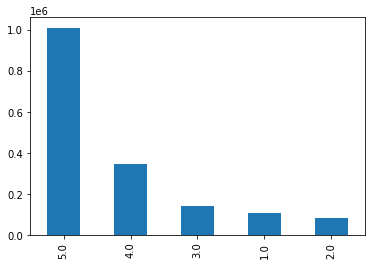

In [9]:
dfextracted['overall'].value_counts().plot(kind ='bar')

In [10]:
## Lets consider Ratings above 3 as positive and 3 as neutral and below 3 as negetive
def sentiment(rating):
  if rating > 2:
    return "Positive"
  elif rating < 3:
    return "Negative"

In [11]:
dfextracted['sentiments'] = dfextracted['overall'].apply(sentiment)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


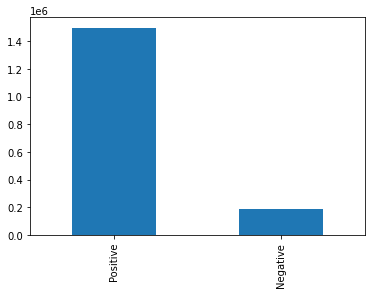

In [12]:
dfextracted['sentiments'].value_counts().plot(kind = 'bar')

Let’s briefly look at the distribution of the ‘Sentiments’ in our dataset. And as shown, we are observing imbalanced data! This could be harmful to our machine learning classifiers as these algorithms expect an equal number of examples per class to perform properly.

Thus, we apply a simple code that will sort out an equal number of observations for each class.

In [13]:
# Note in this dataset the minimum reviews are present for neutral sentiment. So we will balance this dataset taking Neutral value as reference.

In [14]:
# drop any rows w/ missing values
dfextracted = dfextracted.dropna()

In [15]:
# More data more time so we will take only 50000 reviews of each.
sample_size = 50000 
# set sample size to labels w/ minimum count
df_balanced = pd.DataFrame()
for i in dfextracted.sentiments.unique():
  X = dfextracted[dfextracted.sentiments == i].sample(sample_size)
  df_balanced = df_balanced.append(X)

In [16]:
df_balanced['sentiments'].value_counts()

Positive    50000
Negative    50000
Name: sentiments, dtype: int64

In [17]:
# Lets save this dataset because I am using a Google colab and the dataset is taking up more RAM
#df_balanced.to_csv('df_balanced')

In [18]:
#df_balanced = pd.read_csv('/content/df_balanced')

## Text preprocessing
For NLP projects, text preprocessing is traditionally a vital step as it has a potential impact on the final performance of our classifier model. Such a process not only reduces the dimensionality of the input data but also converts the input text into a form that is more meaningful or predictable.

### Step 1: Fundamental preprocessing tasks
Some fundamental text preprocessing steps include lowercasing, punctuations removal, and removal of stopwords.

In [19]:
stopwords_list = stopwords.words('english')

def ReviewProcessing(df):
  # remove non alphanumeric 
  df['review_cleaned'] = df.reviewText.str.replace('[^a-zA-Z0-9 ]', '')
  # lowercase
  df.review_cleaned = df.review_cleaned.str.lower()
  # split into list
  df.review_cleaned = df.review_cleaned.str.split(' ')
  # remove stopwords
  df.review_cleaned = df.review_cleaned.apply(lambda x: [item for item in x if item not in stopwords_list])
  return df 

### Step 2: Lemmatization
Lemmatization is the process of grouping inflected words into a root word. For instance, the word ‘ran’ is lemmatized into ‘run’, ‘crying’ into ‘cry’, and ‘better’ into ‘good’. Although processing time could take a while, lemmatizing is critical for reducing the number of unique words and also, reduce any noise (=unwanted words).

In [20]:
def get_wordnet_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

  return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = nltk.stem.WordNetLemmatizer()
def get_lemmatize(sent):
  return " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sent)])


In [21]:
clean_data = ReviewProcessing(df_balanced)
clean_data.review_cleaned = clean_data.review_cleaned.apply(' '.join)
clean_data['review_cleaned_lemmatized'] = clean_data.review_cleaned.apply(get_lemmatize)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


## Word Vectorization (Embedding)

Word Embeddings is an NLP technique where words or phrases are represented in numerical values in pre-defined vector space. This process is inevitable as in the perspective of machine comprehension, raw strings or text formats cannot be used as input data for machine learning algorithms and deep learning architectures. While there exist numerous approaches such as Bag of Words, TF-IDF, word2vec, and GloVe, we will focus on TF-IDF for our project.

TF-IDF (Term Frequency-Inverse Document Frequency) is a scoring measure generally used in the field of information retrieval that helps understand how important or relevant a term is within the sentence and a given collection of sentences (= documents).

## ML Classifiers for Multi-Classification

1. Multinomial Naive Bayes Classifier
is one of the simple but powerful algorithms used for classification problems. It is based on the Bayes Theorem with an assumption that all observed features are independent of each other. In our project’s case, it would be assuming that every word in a review is independent of the other ones.

2. Linear Support Vector Machine
is a linear classifier which is optimized by Stochastic Gradient Descent. SGD algorithm computes the minimum of the cost function through iteratively updating the gradient with a randomly selected single sample.

3. Logistic Regression Classifier
is a common supervised machine learning algorithm for categorizing data into binary or multiple groups with discrete prediction values. It is a regression model based on the sigmoid function for computing the probability of each data points belonging to the categories. It follows the assumption that there exists a linear relationship between the logit of independent variables and the response.

4. Random Forest Classifier
is a ensemble method where it builds decision trees on different samples and takes their majority vote for classification and average in case of regression.

In [22]:
from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([('vectorize', CountVectorizer(ngram_range=(1, 2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier()),
               ])


from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(max_iter=500)),
               ])


from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier()),
               ])

### Label Encoding

In [23]:
# Lets first split the dataset
x = clean_data['review_cleaned_lemmatized']
y = clean_data['sentiments']

# Import label encoder 
from sklearn import preprocessing
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'Country'. 
y= label_encoder.fit_transform(y)

In [24]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state = 44)


## Evaluation Metrics
For evaluating our candidate model for the prediction of sentiment multi-classification, we will be using accuracy on the test data set. Accuracy is a metric simply dividing # of correct predictions by the total # of predictions. We concluded that accuracy would be the most appropriate and concise measure as we previously re-sampled our initial data to become well balanced.

# Choosing the best Classifier.

In [26]:
# Naive Bayes
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print(accuracy_score(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

# SGD Classifier
sgd.fit(X_train, y_train)
y_pred_sgd = sgd.predict(X_test)
print(accuracy_score(y_test, y_pred_sgd))
print(confusion_matrix(y_test, y_pred_sgd))
print(classification_report(y_test, y_pred_sgd))

# Logistic Regression
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
print(accuracy_score(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

# Random Forest
"""rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))"""

0.8369
[[8793 1207]
 [2055 7945]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84     10000
           1       0.87      0.79      0.83     10000

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000

0.84955
[[8485 1515]
 [1494 8506]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     10000
           1       0.85      0.85      0.85     10000

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000

0.85855
[[8586 1414]
 [1415 8585]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     10000
           1       0.86      0.86      0.86     10000

    accuracy                           0.86     20000
   macro avg       0.86 

'rf.fit(X_train, y_train)\ny_pred_rf = rf.predict(X_test)\nprint(accuracy_score(y_test, y_pred_rf))\nprint(confusion_matrix(y_test, y_pred_rf))\nprint(classification_report(y_test, y_pred_rf))'

Logistic Regression gives the best accuraccy of 85.8%. We will do a Hyper-parameter tuning to improve the logistic Regression model further.

## Hyperparameter Tuning
Overall, our initial approach for ML models concluded that the logistic regression classifier shows the best sentiment classification performance with 0.857 accuracies. Hence, we seek to tune the hyperparameters of this model with the gridsearchCV library.

> C (Inverse Regularization Parameter):
The inverse regularization parameter C in logistic regression is a control variable that is inversely positioned to the lambda regulator. It can be regarded as a method of controlling the overfitting of the regression model. Hence, a higher value of C indicates a stronger impact on the regularization strength. The grid of this parameter was [0.01, 0.1, 1].

> Optimization Algorithms
- ‘lbfgs’: Algorithm that approximates the estimated Hessian matrix by updating with approximate gradient evaluations.
- ‘sag’: ‘sag’ algorithm is generally faster than other algorithms due to its benefit of using a random sample of previous gradient values for obtaining a faster convergence rate. Thus, it is generally preferred for large datasets.
- ‘saga’: ‘saga’ algorithm is a variant from ‘sag’, as it allows to handle non-smooth L1 penalty regularization. Similar to ‘saga’, it is suitable for large datasets.

In [29]:
from sklearn.model_selection import GridSearchCV

grid=[{'clf__solver': ['lbfgs', 'sag', 'saga'],
       'clf__C': [0.01, 0.1, 1]}]
lr = GridSearchCV(logreg, param_grid = grid, cv = 5, scoring='accuracy', verbose = 1, n_jobs = -1)
best_model = lr.fit(X_train, y_train)

print(best_model.best_estimator_)
print(best_model.best_score_)

y_pred_grid = best_model.predict(X_test)
print(confusion_matrix(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))
print(accuracy_score(y_test, y_pred_grid))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=1, max_iter=500))])
0.8534499999999999
[[8586 1414]
 [1415 8585]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     10000
           1       0.86      0.86      0.86     10000

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000

0.85855


The result of the gridsearchCV showed there is no improvement and C=1, and solver=’saga’ are the best estimator.

In [28]:
# Saving the best model
import pickle

pickle.dump(logreg, open('logreg.pkl', 'wb'))